# Image Debluring and Poission Stitching
- Author: Zhen Tong 120090694 
- April 1


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import os


###   Part 1. The "Constrained Least Squares Filtering" (CLSF)
####  Step 0. Get the noised Image

(711, 711, 3)


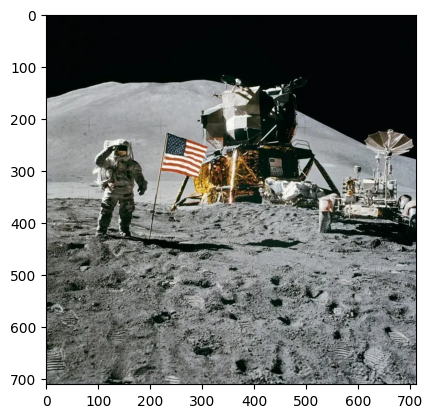

In [2]:
# img_path = "../data/a44w9-kvhmn.jpg"
img_path = "../data/Apollo_15_flag_rover_LM_Irwin-1200x1200.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)

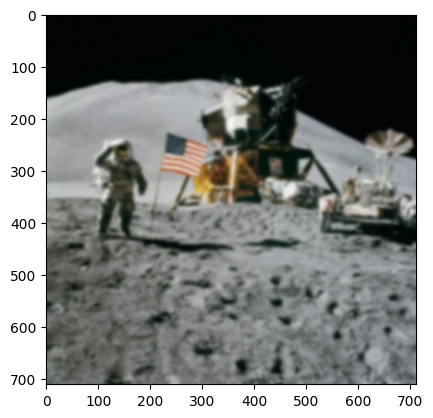

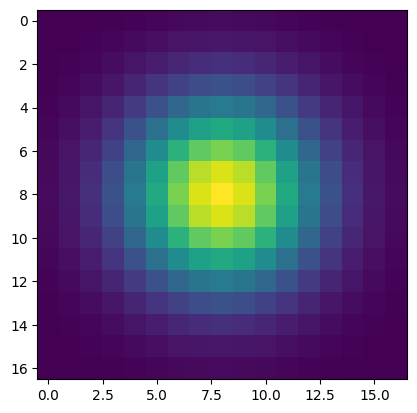

In [4]:
def get_gaussian_kernel(k_size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(k_size-1)/2)**2 + (y-(k_size-1)/2)**2)/(2*sigma**2)), (k_size, k_size))
    return kernel / np.sum(kernel)

def add_gaussian_noise(img:np.ndarray, k_size = 17, sigma0 = 3, \
                        sigma_r = 0.01, sigma_g = 0.03, sigma_b = 0.1):
    
    kernel = get_gaussian_kernel(k_size, sigma0)
    b_x = np.zeros_like(img).astype(np.float64)
    for i in range(3):  # 3 channels for RGB
        b_x[:,:,i] = cv2.filter2D(img[:,:,i], -1, kernel, borderType=cv2.BORDER_REPLICATE)


    h, w, c = img.shape    
    noise = np.zeros_like(img)
    noise[:, :, 0] = np.random.normal(0, sigma_r, (h, w))
    noise[:, :, 1] = np.random.normal(0, sigma_g, (h, w))
    noise[:, :, 2] = np.random.normal(0, sigma_b, (h, w))

    b_x += noise
    return b_x.astype(np.int32), kernel, noise
    

bias_img, gaussian_kernel, noise = add_gaussian_noise(img)
plt.imshow(bias_img); plt.show()
plt.imshow(gaussian_kernel); plt.show()

#### Step 1. Frequency Domain Transformation

In [5]:
def get_frequency_domain_rgb(img, f_size=(1024, 1024)):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    r_f = np.fft.fft2(r, s=f_size)
    g_f = np.fft.fft2(g, s=f_size)
    b_f = np.fft.fft2(b, s=f_size)

    r_f_shift = np.fft.fftshift(r_f)
    g_f_shift = np.fft.fftshift(g_f)
    b_f_shift = np.fft.fftshift(b_f)

    return r_f_shift, g_f_shift, b_f_shift

F_size = (1024, 1024)
r_f, g_f, b_f = get_frequency_domain_rgb(bias_img, f_size=F_size)
nr_f, ng_f, nb_f = get_frequency_domain_rgb(noise, f_size=F_size)

G_matrix = np.fft.fft2(gaussian_kernel, s=F_size)
G_matrix = np.fft.fftshift(G_matrix)
laplacian_kernel = np.array([[0, 1, 0],
                             [1, -4, 1],
                             [0, 1, 0]])
L_matrix = np.fft.fft2(laplacian_kernel, s=F_size)
L_matrix = np.fft.fftshift(L_matrix)



print(r_f.shape)
print(G_matrix.shape)


(1024, 1024)
(1024, 1024)


/var/folders/8h/gwyjgzb57673j3c0kf0vj5lh0000gn/T/ipykernel_15367/1770312969.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  img[:, :, 0] = np.fft.ifft2(r_f)
/var/folders/8h/gwyjgzb57673j3c0kf0vj5lh0000gn/T/ipykernel_15367/1770312969.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  img[:, :, 1] = np.fft.ifft2(g_f)
/var/folders/8h/gwyjgzb57673j3c0kf0vj5lh0000gn/T/ipykernel_15367/1770312969.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  img[:, :, 2] = np.fft.ifft2(b_f)


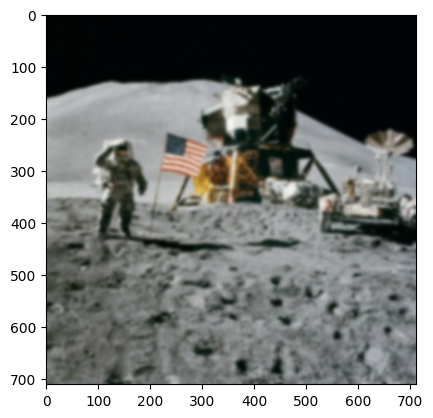

In [6]:
def get_spatial_domain_rbg(r_f, g_f, b_f, img_size):
    h, w, c = img_size
    f_h, f_w = r_f.shape
    img = np.zeros((f_h, f_w, 3))
    
    r_f = np.fft.ifftshift(r_f)
    g_f = np.fft.ifftshift(g_f)
    b_f = np.fft.ifftshift(b_f)

    img[:, :, 0] = np.fft.ifft2(r_f)
    img[:, :, 1] = np.fft.ifft2(g_f)
    img[:, :, 2] = np.fft.ifft2(b_f)

    img = img[:h, :w, :]
    img = np.abs(img)
    return img.astype(np.int32)

f2img = get_spatial_domain_rbg(r_f, g_f, b_f, img.shape)
plt.imshow(f2img)